In [131]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [132]:
pylab.style.use('ggplot')

In [133]:
import pyrec

In [134]:
import ciso8601
class DataParserTime:
    def __init__(self, delim="\t"):
        self.delim = delim
        
    def parse(self, line):
        splitted = line.strip().split(self.delim)
        d = ciso8601.parse_datetime(splitted[-1])
        return (splitted[0], splitted[1], d.strftime('%s'))
    
class DataParser:
    def __init__(self, delim="\t"):
        self.delim = delim
    def parse(self, line):
        splitted = line.strip().split(self.delim)
        return (splitted[0], splitted[1], "1.0")
    
class InfoParser:
    def __init__(self, delim="\t"):
        self.delim = delim
        
    def parse(self, line):
        splitted = line.strip().split(self.delim)
        return (splitted[0], splitted[1])


In [135]:
def id2name(fname, parser):
    id2name = {}
    with open(fname) as fp:
        for line in fp:
            item, name = parser.parse(line)
            id2name[item] = name
    return id2name

In [136]:
import scipy.sparse
import numpy as np
def keepTopKSimilarity(mat, k):
    if not isinstance(mat, scipy.sparse.csc_matrix):
        mat = mat.tocsc()
        mat.sort_indices()
    m, n = mat.shape
    data, ci, rptr = mat.data, mat.indices, mat.indptr
    for i in range(0, n):
        data_indices = np.arange(rptr[i], rptr[i + 1])
        sorted_indices = np.argsort(data[data_indices])[::-1]
        data[(sorted_indices + rptr[i])[k:]] = 0.0
    mat.eliminate_zeros()
    return mat

def removeAlreadyPurchasedUsers(reco, train):
    temp = train.copy()
    temp.data[:] = float("-inf")
    reco = reco + temp
    reco.data[np.where(reco.data==float("-inf"))[0]] = 0.0
    return reco

In [137]:
def histogram_unary(data):
    _max = int(data.max())
    x = range(_max + 1)
    y = [0]* (_max + 1)
    for i in data:
        y[int(i)] += 1
    return x, y

In [241]:
from pyrec.utils.data_utils.data import Data, loadDataset
from pyrec.utils.data_utils.lineParser import UserItemRatingParser
from pyrec.evaluate.eval_ranking_metric import evalMetrics

In [139]:
train_path = "/data3/ssedhain/datasets/movielens/1M/implicitfolds/train.1"
test_path = "/data3/ssedhain/datasets/movielens/1M/implicitfolds/test.1"
item_info = "/data3/ssedhain/datasets/movielens/1M/movies.dat"

In [216]:
parser = DataParser()
d = Data()
d.import_data(train_path, parser)
train = d.R
test, _ = loadDataset(test_path, d.users, d.items, parser)

Loading data: [============================================] 100% Time: 0:00:01
Loading data: [============================================] 100% Time: 0:00:00


In [141]:
from pyrec.recommender.linear_models.neighborhood.knn import KnnReco
from pyrec.recommender.modelArgs import KnnArgs
from pyrec.utils.distance_metric.similarity import cosineSimilarity

<h1> Knn Based Recommendation </h1>

In [142]:
args = KnnArgs(cosineSimilarity, 50, "user")
model = KnnReco(args)

In [151]:
reco = model.recommend_all(train)
reco = removeAlreadyPurchasedUsers(reco, train)
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))


In [153]:
reco.eliminate_zeros()
print reco.data

[ 8.8875751   4.54734053  5.7838103  ...,  0.1796053   0.1796053   0.1796053 ]


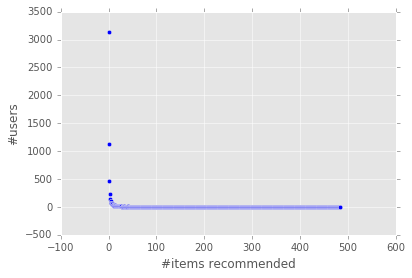

In [144]:
pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

### Conclusion
Standard knn (where we revert the role of user and items) most of the users dont get any recommendation i.e. most of the items are reommended to the power users

<h3>Correlation between number of purchased items vs recommended items</h3>

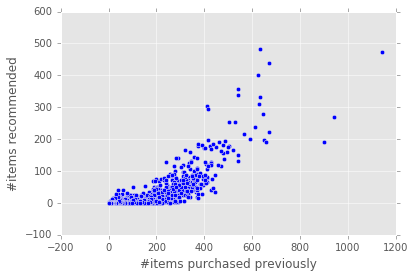

In [145]:
x = d.R.sum(axis=1)
y = topk_users_binarized.sum(axis=1)
pylab.scatter(x,y)
pylab.xlabel("#items purchased previously")
pylab.ylabel("#items recommended")

### Conclusion
The above plot shows positive correlation between #purchased items and #recommended items

<h2>Normalize recommendation score by #purchased items</h2>

In [155]:
reco = model.recommend_all(train)
reco = removeAlreadyPurchasedUsers(reco, train)
reco = scipy.sparse.csr_matrix(reco / train.sum(axis=1))
topk_users = keepTopKSimilarity(reco, 10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0


In [156]:
x, y = histogram_unary(topk_users_binarized.sum(axis=1))

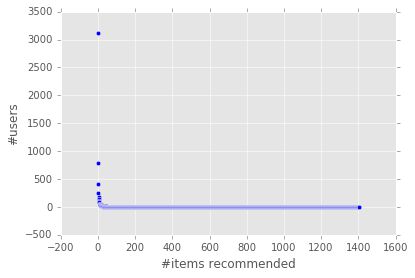

In [157]:
pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

### Conclusion
Normalizing the score for each user by #item purchases before finding top-k users to recommend doesnt help

In [162]:
reco = model.recommend_all(train)
reco = removeAlreadyPurchasedUsers(reco, train)
sim = model.sim.copy()
sim.data[:] = 1.0
reco = scipy.sparse.csr_matrix(np.divide(reco, (train.T * sim).T))
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))


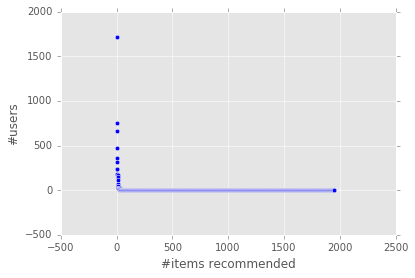

In [163]:
pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

In [166]:
import numpy as np
def softmax(mat, axis):
    val = np.exp(mat.todense())
    sm = val.sum(axis=axis)
    return val/sm
    

In [167]:
reco = model.recommend_all(train)
reco = removeAlreadyPurchasedUsers(reco, train)
reco = scipy.sparse.csr_matrix(softmax(reco, axis=1))
topk_users = keepTopKSimilarity(reco, 10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0

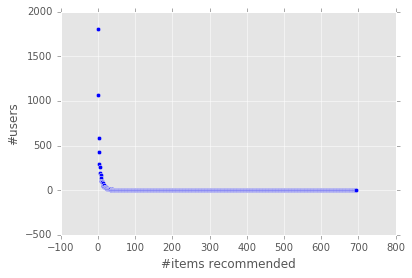

In [171]:
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))

pylab.scatter(x,y)
# pylab.xscale("log")
# pylab.yscale("log")
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

<h2>Linear recommendation models</h2>

In [172]:
from pyrec.recommender.linear_models.regression_models.sparse_linear import  SparseLinear
from pyrec.recommender.modelArgs import SparseLinearArgs

In [176]:
from sklearn.linear_model import SGDRegressor, SGDClassifier
import scipy.sparse
import numpy as np
from pyrec.recommender.linear_models.regression_models.base import BaseLinear
from pyrec.parallel.ipythonParallelLinear import ParallelRunner



class args(object):
    """docstring for args"""
    def __init__(self):
        super(args, self).__init__()
    
    def __str__(self):
        fields = []
        for key, value in self.__dict__.items():
            fields.append( "%s : %s" % (str(key), str(value)) )
        return "\n".join(fields)


class SparseLinearArgs(args):

    """docstring for SparseLinearArgs"""

    def __init__(self, l1, l2, mtype, loss, penalty, intercept=False, problem="classification"):
        super(SparseLinearArgs, self).__init__()
        self.l1 = l1
        self.l2 = l2
        self.model_type = mtype
        self.loss = loss
        self.penalty = penalty
        self.intercept = intercept
        self.problem = problem
        
class SparseLinear(BaseLinear):

    """docstring for SparseLinear"""

    def __init__(self, arg):
        super(SparseLinear, self).__init__()
        self.arg = arg
        self.target = None
        self.__initargs()

    def __initargs(self):
        self.alpha = self.arg.l1 + self.arg.l2
        self.l1_ratio = self.arg.l1 / self.alpha
        self.loss = self.arg.loss
        self.penalty = self.arg.penalty
        self.intercept = self.arg.intercept
        self.model_type = self.arg.model_type
        self.problem = self.arg.problem

    def __getLearner(self):
        if self.problem == "classification":
            return SGDClassifier(loss=self.loss, penalty=self.penalty,
                                alpha=self.alpha, l1_ratio=self.l1_ratio,
                                fit_intercept=self.intercept)

        else:
            return SGDRegressor(loss=self.loss, penalty=self.penalty,
                                alpha=self.alpha, l1_ratio=self.l1_ratio,
                                fit_intercept=self.intercept)

    def fit(self, train_input, train_target, target_indices=None):
        import numpy as np
        import scipy.sparse
        models = []
        if self.model_type == "user":
            train_target = train_target.T
            train_input = train_input.T
        if target_indices is not None:
            train_target = train_target[:, target_indices]
        else:
            target_indices = range(train_target.shape[1])
        #for fast column access
        train_target = train_target.tocsc()
        for i, index in enumerate(target_indices):
            learner = self.__getLearner()
            y = np.ravel(train_target.getcol(i).todense())
            learner.fit(train_input, y)
            models.append(learner.coef_)
        self.sim = scipy.sparse.csc_matrix(np.vstack(models).T)
        return target_indices, self.sim

    def fit_parallel(self, train_input, train_target,
                     target_indices=None, num_procs=5,
                     batch_size=1000):
        prunner = ParallelRunner(self, num_procs, batch_size)
        indices, sim = prunner.fit(train_input, train_target)
        self.sim = sim
        return indices, self.sim

    def recommend_all(self, train_input):
        if self.model_type == "item":
            score = train_input * self.sim
        elif self.model_type == "user":
            score = (self.sim.T * train_input).tocsr()
        return score

    def recommend(self, users, train_input):
        if self.model_type == "item":
            reco = train_input[users, :] * self.sim
        if self.model_type == "user":
            reco = (self.sim[:, users].T * train_input)
        return reco.todense()



In [177]:
args = SparseLinearArgs(0.0001, 0.01, "item", "log", "elasticnet")
args.model_type = "item"
model = SparseLinear(args)

In [178]:
indices, sim = model.fit(train, train)

In [179]:
reco = train * model.sim
reco = removeAlreadyPurchasedUsers(reco, train)
topk_users = keepTopKSimilarity(reco, 10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0

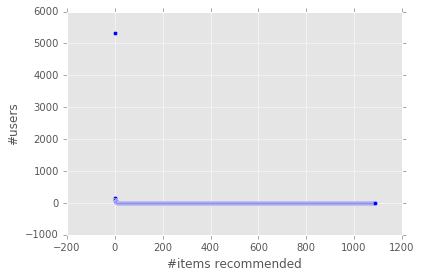

In [180]:
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))

pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

<h2> Via Linear Regression </h2>

In [247]:
lbda = 1000
reco = train * ((np.linalg.inv((train.T * train + lbda * scipy.sparse.eye(train.shape[1])).todense())) * train.T * train)
reco = scipy.sparse.csr_matrix(reco)
print evalMetrics(train.T.tocsr(), test.T.tocsr(), reco.T.tocsr())

(0.017613779172819324, array([ 0.07563204,  0.06991714,  0.06210962,  0.05331421]), array([ 0.00896881,  0.01252134,  0.02056728,  0.03223416]), 3138)
(0.035873337168266607, array([ 0.1179095 ,  0.10943276,  0.0971638 ,  0.08446463]), array([ 0.01715021,  0.02422209,  0.03896956,  0.06209693]), 3138)
(0.069542610299165419, array([ 0.19407266,  0.17724665,  0.15803059,  0.13440089]), array([ 0.02872427,  0.0420227 ,  0.06777144,  0.10486751]), 3138)
(0.096983448872938097, array([ 0.2654557 ,  0.24110899,  0.20643722,  0.17232314]), array([ 0.04134793,  0.05830512,  0.09174684,  0.14390735]), 3138)


In [248]:
reco = removeAlreadyPurchasedUsers(reco, train)
topk_users = keepTopKSimilarity(reco, 10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0

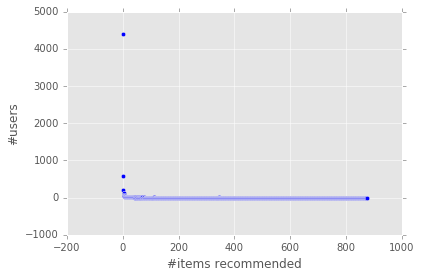

In [249]:
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))

pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")

<h2>Via Matrix Factorization</h2>

In [250]:
from pyrec.recommender.bilinear_models.mf import MF
from pyrec.recommender.modelArgs import WRMFArgs

In [263]:
args = WRMFArgs(0.1, 10)
model = MF(args)
model.fit(train, train)

In [264]:
reco = model.recommend_all(train)
print evalMetrics(train, test, reco)

(0.14436763910669251, array([ 0.30476668,  0.26942867,  0.22482459,  0.179285  ]), array([ 0.06645   ,  0.09368777,  0.15165069,  0.23017172]), 5986)


In [265]:
reco = scipy.sparse.csr_matrix(reco)
reco = removeAlreadyPurchasedUsers(reco, train)
topk_users = keepTopKSimilarity(reco, 10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0

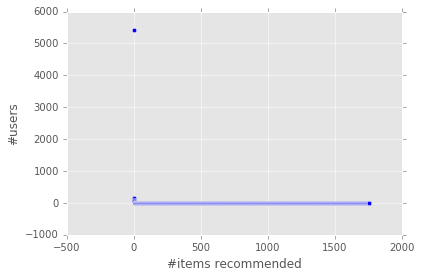

In [266]:
topk_users = keepTopKSimilarity(reco,10)
topk_users_binarized = topk_users.copy()
topk_users_binarized.data[:] = 1.0
x, y = histogram_unary(topk_users_binarized.sum(axis=1))

pylab.scatter(x,y)
pylab.xlabel("#items recommended")
pylab.ylabel("#users")